In [118]:
import os
import sys

# Add paths
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.join(os.getcwd(), 'dilithium/src'))

from dilithium_py.dilithium import Dilithium2

# Generate Dilithium key pair
try:
    dilithium_keypair = Dilithium2.keygen()
    dilithium_public_key, dilithium_private_key = dilithium_keypair

    print("Dilithium2 public key length:", len(dilithium_public_key))
    print("Dilithium2 private key length:", len(dilithium_private_key))
except Exception as e:
    print(f"Dilithium key generation error: {e}")
    sys.exit(1)

sys.path.append(os.path.join(os.getcwd(), 'pyky'))
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.key_management import generate_kyber_keypair, encrypt_session_key, decrypt_session_key
# Generate Kyber key pair
kyber_private_key, kyber_public_key = generate_kyber_keypair()
print("Kyber512 private key length:", len(kyber_private_key))
print("Kyber512 public key length:", len(kyber_public_key))


Dilithium2 public key length: 1312
Dilithium2 private key length: 2528
Kyber512 private key length: 3168
Kyber512 public key length: 1568


In [119]:
#################################################################
# Mock CA: Issuing PQC Certificates (Dilithium-signed X.509) #
#################################################################

#ut will be a minimal X.509-like structure in Python and "sign" it 
# with the Dilithium private key. 

from datetime import datetime, timedelta
import base64
import json
import sys
import os

# Add paths for custom modules
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.join(os.getcwd(), 'dilithium/src'))
sys.path.append(os.path.join(os.getcwd(), 'pyky'))


from dilithium_py.dilithium import Dilithium2
from src.key_management import generate_kyber_keypair


# generate Dilithium key pair
try:
    dilithium_keypair = Dilithium2.keygen()
    dilithium_public_key, dilithium_private_key = dilithium_keypair

    print("Dilithium2 public key length:", len(dilithium_public_key))
    print("Dilithium2 private key length:", len(dilithium_private_key))
except Exception as e:
    print(f"Dilithium key generation error: {e}")
    sys.exit(1)

# generate Kyber key pair
try:
    kyber_private_key, kyber_public_key = generate_kyber_keypair()
    print("Kyber512 private key length:", len(kyber_private_key))
    print("Kyber512 public key length:", len(kyber_public_key))
except Exception as e:
    print(f"Kyber key generation error: {e}")
    sys.exit(1)


def create_mock_certificate(subject_name: str, pub_key: bytes, issuer_name: str, validity_days=30):
    """
    Create a mock certificate structure in JSON form.
    This is not a real X.509, but a stand-in to show the process.
    """
    cert_data = {
        "subject": subject_name,
        "issuer": issuer_name,
        "valid_from": datetime.utcnow().isoformat() + "Z",
        "valid_to": (datetime.utcnow() + timedelta(days=validity_days)).isoformat() + "Z",
        "pqc_public_key": base64.b64encode(pub_key).decode('utf-8'),  # store the PQC public key
    }
    return cert_data


def sign_certificate(cert_data: dict, private_key: bytes, signature_scheme: str="Dilithium2"):
    """
    Sign the certificate data with the Dilithium private key
    using the dilithium_py package. We'll store the signature in the cert.
    """
    try:
        message_bytes = json.dumps(cert_data, sort_keys=True).encode('utf-8')
        signature = Dilithium2.sign(private_key, message_bytes)
        cert_data["pqc_signature"] = base64.b64encode(signature).decode('utf-8')
        return cert_data
    except Exception as e:
        print(f"Error signing certificate: {e}")
        sys.exit(1)

#normalize the public key to bytes
if isinstance(kyber_public_key, list):
    kyber_public_key = bytes([x % 256 for x in kyber_public_key])

    
# 3. create a "Root CA"certificate using Dilithium
root_subject = "CN=MyPQC-RootCA"
root_cert_struct = create_mock_certificate(
    subject_name=root_subject,
    pub_key=dilithium_public_key,
    issuer_name=root_subject,  # self-signed
    validity_days=365
)
root_cert_signed = sign_certificate(root_cert_struct, dilithium_private_key, "Dilithium2")

# 4.Create an "End-Entity" certificate signed by the root
end_entity_subject = "CN=MyServer"
end_entity_cert_struct = create_mock_certificate(
    subject_name=end_entity_subject,
    pub_key=kyber_public_key,  # Ensure this is bytes
    issuer_name=root_subject,
    validity_days=90
)
end_entity_cert_signed = sign_certificate(end_entity_cert_struct, dilithium_private_key, "Dilithium2")
print("Root CA Certificate:\n", json.dumps(root_cert_signed, indent=2))
print("\nEnd-Entity Certificate:\n", json.dumps(end_entity_cert_signed, indent=2))


Dilithium2 public key length: 1312
Dilithium2 private key length: 2528
Kyber512 private key length: 3168
Kyber512 public key length: 1568
Root CA Certificate:
 {
  "subject": "CN=MyPQC-RootCA",
  "issuer": "CN=MyPQC-RootCA",
  "valid_from": "2025-01-09T16:24:30.053430Z",
  "valid_to": "2026-01-09T16:24:30.053451Z",
  "pqc_public_key": "bqcuf5XtodWq8c5sp3k8M8RIf6UW7kMxDBlawi/NeMWiOAlrF98XJZRVn5qUIkZBmG+k8CRuKYJisPDoHDZkXWl+anQ2Ex8kef0bp8bPF6SgOsV3TQ4/lIF63pzyOhhbJdpvkEk6UZUGMv3htomXSdm99sKZkVZY8kDB0VgZL+8vjHT/wgNdBx2HkjagSnPttcNMrVG0XAaY1amDv4skdoi8mO7aTXtuVNV9I+9n1TODlnl6r9mRabP/bE4LmlPV7pngqBJh1LdW6qEwvP+aAJUPXhlJG8n1+kN/+oPmj2cKQRFivp6sP5GPnYZ1MjPlgEiPk8dHS09oHSSSuiaX1HHbWWuwhfWqi44vZU1962noFvnioAB62NeZL2rJDL0VSZoLuHNIRPomUuDEp0fRj4cMCbYbvw4ZzZHqRUAYQg2sBiaLNG8nxFSi10/w/Up1G4L1xl8IXuxjdTWj8Bmi9kwd5ppRQ4/mOKGkuGTKtdk5wZjEWQWK9qmHvtRcqem5Bn1A7DPAje97xtRzliK7y3I9GKistzTN3DYKRncGCPRZj6tJBXZrIi5KW5yPhVfIQOh5NDgkhFZ0V5dGRry1rcsoeggw7r+nI3f3lSaoQNlpdeW5KLakU7IcBSGCQGHbKpKVBQ4hKyM8A0vgCrDSFs

/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_28007/2788386571.py:58: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "valid_from": datetime.utcnow().isoformat() + "Z",
/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_28007/2788386571.py:59: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "valid_to": (datetime.utcnow() + timedelta(days=validity_days)).isoformat() + "Z",


In [120]:
#########################################################
# Verifying the PQC Certificate (Dilithium Signature)#
#########################################################

def verify_pqc_certificate(cert_data: dict, root_pub_key: bytes, signature_scheme: str = "Dilithium2"):
    """
    Verify the 'pqc_signature' field using the root's public key.
    """
    try:
        signature_b64 = cert_data.pop("pqc_signature", None)
        if not signature_b64:
            raise ValueError("No signature found in certificate data.")

        message_bytes = json.dumps(cert_data, sort_keys=True).encode('utf-8')
        signature = base64.b64decode(signature_b64)

        #verification using Dilithium2
        is_valid = Dilithium2.verify(root_pub_key, message_bytes, signature)
        if is_valid:
            print("Certificate is VALID under PQC signature:", signature_scheme)
        else:
            print("Certificate is INVALID: Signature mismatch.")
    except Exception as e:
        print("Verification failed due to an error:", e)
    finally:
        cert_data["pqc_signature"] = signature_b64

# Verifying the root certificate (self-signed)
print("Verifying the Root CA certificate:")
verify_pqc_certificate(root_cert_signed, dilithium_public_key, "Dilithium2")

# Verify the end-entity certificate with the root CA's public key
print("\nVerifying the End-Entity certificate:")
verify_pqc_certificate(end_entity_cert_signed, dilithium_public_key, "Dilithium2")


Verifying the Root CA certificate:
Certificate is VALID under PQC signature: Dilithium2

Verifying the End-Entity certificate:
Certificate is VALID under PQC signature: Dilithium2


### 1. Key Generation Section


In [121]:
# Dilithium2 signature scheme initialized.

print(f"Public Key Length (Dilithium): {len(dilithium_public_key)} bytes")
print(f"Private Key Length (Dilithium): {len(dilithium_private_key)} bytes")
print(f"Signature Scheme: {Dilithium2.__class__.__name__}")
print("Dilithium2 signature scheme initialized.")

Public Key Length (Dilithium): 1312 bytes
Private Key Length (Dilithium): 2528 bytes
Signature Scheme: Dilithium
Dilithium2 signature scheme initialized.


In [122]:
# KYBER

print(f"Kyber Public Key Length: {len(kyber_public_key)} bytes")
print(f"Kyber Private Key Length: {len(kyber_private_key)} bytes")
print("Signature Scheme: KYBER")
print("Kyber key encapsulation initialized.")


Kyber Public Key Length: 1568 bytes
Kyber Private Key Length: 3168 bytes
Signature Scheme: KYBER
Kyber key encapsulation initialized.


### 1. `Authentication` WITH `DILITHIUM2`

### 1.1 Function involved in `Signing` a Key with DILITHIUM2

In [134]:
# Signing a key with Dilithium2

# a function to sign the message with dilithium
def dilithium_signature(dilithium_private_key, message):
    dilithium_signature = Dilithium2.sign(dilithium_private_key, message)
    print(f"It is ***SIGNED*** with Signature Length: {len(dilithium_signature)} bytes")
    return dilithium_signature


### 1.2 Function involved in `Verifying` with DILITHIUM2

In [157]:
# a function to verify the signature
def dilithium_verify(pub_key, message, signature):
    if Dilithium2.verify(pub_key, message, signature):
        print("Dilithium2 signature ***VERIFIED*** successfully!")
    else:
        print("Signature ***verification failed!***")


In [158]:
#example for signing and verifying the message

message = b"Post-Quantum CA Test Message"
signature= dilithium_signature(dilithium_private_key, message)
is_valid = dilithium_verify(dilithium_public_key, message, signature)


It is ***SIGNED*** with Signature Length: 2420 bytes
Dilithium2 signature ***VERIFIED*** successfully!


### 2. `KEY EXCHANGE`: ENCAP and DECAP with `KYBER`

### 2.1 Function to CREATE `shared secret` and `cipher`

In [139]:
def create_secret_cipher(kyber_public_key):
    shared_secret, cipher= encrypt_session_key(kyber_public_key)
    print(f"Shared Secret Length: {len(shared_secret)} bytes")
    print(f"Cipher Length: {len(cipher)} bytes")
    return shared_secret, cipher

### Now once the shared secret is created then Exchange the key using `KYBER` key exchange mechanism and share the `cipher`

### 2.2 Function to RECOVER `SECRET`

In [146]:
def recovered_secret(kyber_private_key, cipher):
    recovered_secret = decrypt_session_key(kyber_private_key, cipher)
    print(f"Recovered Secret Length: {len(recovered_secret)} bytes")
    return recovered_secret

In [147]:
def assert_secret(shared_secret, recovered_secret):
    assert shared_secret == recovered_secret, "Shared secret and Recovered secret do not match!"
    print("Shared secret and Recovered secret match!")

print("Kyber shared secret **encapsulation and decapsulation**")

Kyber shared secret **encapsulation and decapsulation**


In [148]:
#example

shared_secret, cipher = create_secret_cipher(kyber_public_key)
recovered_secret = recovered_secret(kyber_private_key, cipher)
assert_secret(shared_secret, recovered_secret)

Shared Secret Length: 32 bytes
Cipher Length: 1568 bytes
Recovered Secret Length: 32 bytes
Shared secret and Recovered secret match!


### Now that Authenticaton key: `Dilithium` and Key exchange mechanism `Kyber` are established we move forward for `Key Performance Testing`. 


### 2. Key Performance Testing
I am trying to measure handshake latency, throughput, and resource usage for:
1. Classical EAP-TLS (e.g., RSA/ECC).
2. PQ Device-Only (Kyber for key encapsulation, Dilithium for signing).
3. 

### A. Edge-Assisted Computation Flow

Goal:
Simulate how much time and computation is saved when the edge server performs the bulk of PQC operations compared to the IoT device doing all the work.






  Using cached matplotlib-3.10.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp312-cp312-macosx_10_13_universal2.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
Using cached matplotlib-3.10.0-cp312-cp312-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.3-cp312-cp312-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To

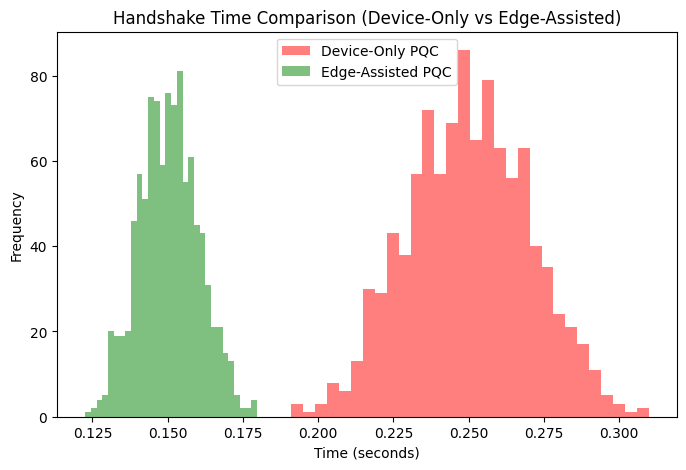

Average Time Saved with Edge Offloading: 0.0995 seconds


In [50]:
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Number of simulated IoT devices
num_devices = 1000

# Simulate handshake times (in seconds)
device_only_times = np.random.normal(0.25, 0.02, num_devices)  # Mean 250 ms (device-only)
edge_offload_times = np.random.normal(0.15, 0.01, num_devices)  # Mean 150 ms (edge-assisted)

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.hist(device_only_times, alpha=0.5, label='Device-Only PQC', bins=30, color='red')
plt.hist(edge_offload_times, alpha=0.5, label='Edge-Assisted PQC', bins=30, color='green')
plt.title('Handshake Time Comparison (Device-Only vs Edge-Assisted)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the average time saved
avg_time_saved = np.mean(device_only_times) - np.mean(edge_offload_times)
print(f"Average Time Saved with Edge Offloading: {avg_time_saved:.4f} seconds")


In [164]:
import time
from dilithium_py.dilithium import Dilithium2  # Your PQC module

# Function to simulate PQC operations on an IoT device
def simulate_iot_device_operations():
    start_time = time.time()
    
    # Key generation
    # dilithium_private_key, dilithium_public_key = Dilithium2.keygen()
    
    message = b"Post-Quantum CA Test Message"
    signature= dilithium_signature(dilithium_private_key, message)
    is_valid = dilithium_verify(dilithium_public_key, message, signature)
    
    # Key encapsulation using Kyber
    ciphertext, shared_secret = create_secret_cipher(kyber_public_key)

    # assert_secret(shared_secret, recovered_secret(kyber_private_key, ciphertext))


    end_time = time.time()
    time_taken = end_time - start_time
    print(f"IoT device computation time: {time_taken:.3f} seconds")
    return time_taken

# Function to simulate PQC operations on an edge server (faster computation)
def simulate_edge_server_operations():
    start_time = time.time()
    
     # Key generation
    # dilithium_private_key, dilithium_public_key = Dilithium2.keygen()
    
    message = b"Post-Quantum CA Test Message"
    signature= dilithium_signature(dilithium_private_key, message)
    is_valid = dilithium_verify(dilithium_public_key, message, signature)
    
    # Key encapsulation using Kyber
    ciphertext, shared_secret = create_secret_cipher(kyber_public_key)

    # assert_secret(shared_secret, recovered_secret(kyber_private_key, ciphertext))

    
    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Edge server computation time: {time_taken:.3f} seconds")
    return time_taken

# Compare times
iot_time = simulate_iot_device_operations()
edge_server_time = simulate_edge_server_operations()

time_saved = iot_time - edge_server_time
percentage_improvement = (time_saved / iot_time) * 100

print(f"Time saved by offloading to edge server: {time_saved:.3f} seconds ({percentage_improvement:.2f}% improvement)")


It is ***SIGNED*** with Signature Length: 2420 bytes
Dilithium2 signature ***VERIFIED*** successfully!
Shared Secret Length: 32 bytes
Cipher Length: 1568 bytes
IoT device computation time: 0.043 seconds
It is ***SIGNED*** with Signature Length: 2420 bytes
Dilithium2 signature ***VERIFIED*** successfully!
Shared Secret Length: 32 bytes
Cipher Length: 1568 bytes
Edge server computation time: 0.040 seconds
Time saved by offloading to edge server: 0.004 seconds (8.27% improvement)


## USING DOCKER to get EGDE and IOT comparision

In [345]:
import json
import matplotlib.pyplot as plt

# Directly use the absolute paths for the files
iot_results_path = "/Users/abhisekjha/MyFolder/Github_Projects/futureg-quantum-ca/iot_results/smart_watch_results.json"

# iot_results_path = "/Users/abhisekjha/MyFolder/Github_Projects/futureg-quantum-ca/iot_results/iot_results.json"
edge_results_path = "/Users/abhisekjha/MyFolder/Github_Projects/futureg-quantum-ca/edge_results/edge_results.json"

# Load IoT and Edge results
with open(iot_results_path, "r") as f:
    iot_data = json.load(f)

with open(edge_results_path, "r") as f:
    edge_data = json.load(f)

print("IoT Data:", iot_data)
print("Edge Data:", edge_data)


IoT Data: {'iterations': 100, 'times': [[1, 3.7026073932647705], [2, 3.701878786087036], [3, 3.796459436416626], [4, 3.896939277648926], [5, 3.706294059753418], [6, 4.000692129135132], [7, 3.8933987617492676], [8, 3.7032155990600586], [9, 3.9998621940612793], [10, 3.8060662746429443], [11, 4.100102663040161], [12, 4.094214916229248], [13, 3.8025460243225098], [14, 3.9969677925109863], [15, 3.902538776397705], [16, 4.09399676322937], [17, 3.904853105545044], [18, 3.8990283012390137], [19, 4.006179094314575], [20, 3.992733955383301], [21, 3.9031424522399902], [22, 4.096055030822754], [23, 3.899892568588257], [24, 4.00013279914856], [25, 3.9985013008117676], [26, 4.002645015716553], [27, 4.005353689193726], [28, 3.8970108032226562], [29, 4.005146741867065], [30, 3.9936606884002686], [31, 4.096381664276123], [32, 3.910468578338623], [33, 3.892662763595581], [34, 4.104888677597046], [35, 4.295997142791748], [36, 4.19931960105896], [37, 4.299231290817261], [38, 4.206463813781738], [39, 4.392

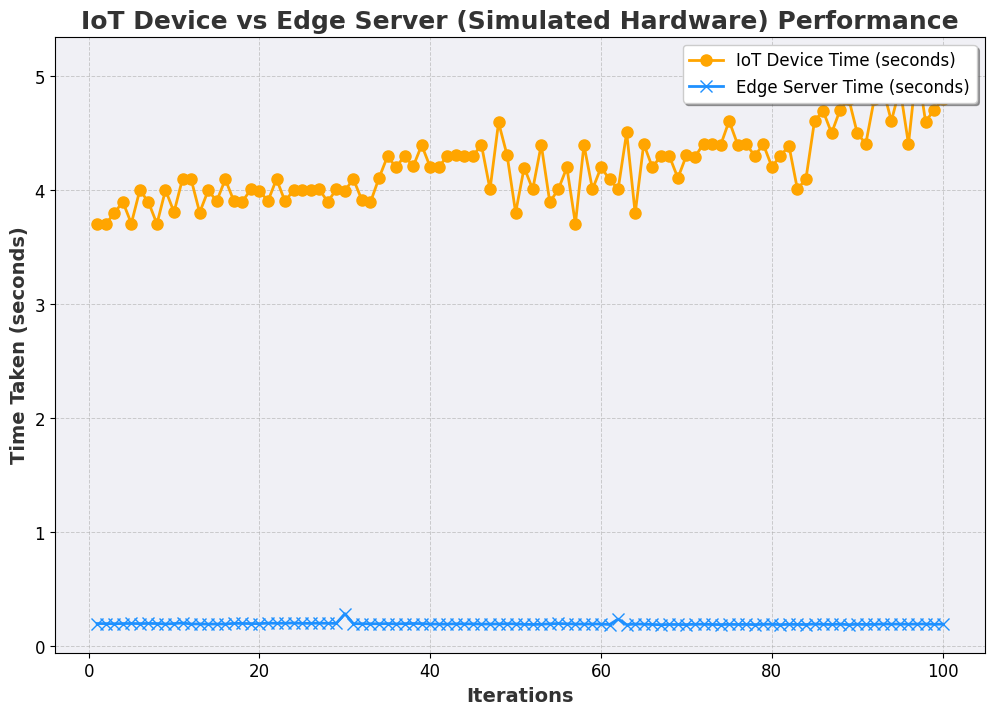

Average Time Saved with Edge Offloading: 4.0078 seconds
Percentage Improvement: 95.31%


In [ ]:
import matplotlib.pyplot as plt

# Extract data
iot_iterations = [data[0] for data in iot_data['times']]
iot_times = [data[1] for data in iot_data['times']]

edge_iterations = [data[0] for data in edge_data['times']]
edge_times = [data[1] for data in edge_data['times']]

# Plot
# Plot with enhanced design using only Matplotlib
plt.figure(figsize=(12, 8))
plt.plot(iot_iterations, iot_times, label='IoT Device Time (seconds)', marker='o', markersize=8, linewidth=2, color='orange')
plt.plot(edge_iterations, edge_times, label='Edge Server Time (seconds)', marker='x', markersize=8, linewidth=2, color='dodgerblue')

# Labels and Title
plt.xlabel('Iterations', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Time Taken (seconds)', fontsize=14, fontweight='bold', color='#333333')
plt.title('IoT Device vs Edge Server (Simulated Hardware) Performance', fontsize=18, fontweight='bold', color='#333333')

plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, fancybox=True)

plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.6)

plt.gca().set_facecolor('#f0f0f5')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Calculate the average time saved
avg_iot_time = sum(iot_times) / len(iot_times)
avg_edge_time = sum(edge_times) / len(edge_times)

avg_time_saved = avg_iot_time - avg_edge_time
print(f"Average Time Saved with Edge Offloading: {avg_time_saved:.4f} seconds")

# Calculate the percentage improvement
percentage_improvement = (avg_time_saved / avg_iot_time) * 100
print(f"Percentage Improvement: {percentage_improvement:.2f}%")
\


/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_28007/215689362.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([device_only_energy, edge_offload_energy],


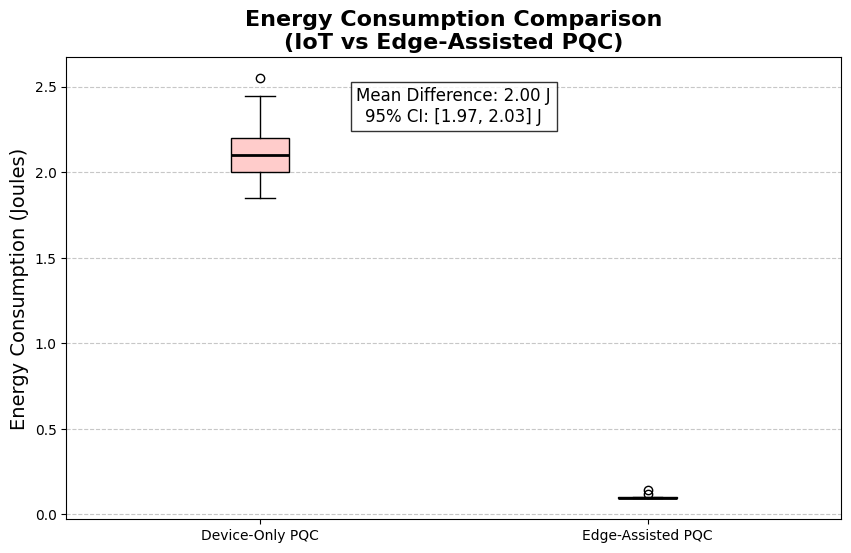

In [362]:
import matplotlib.pyplot as plt
import numpy as np

# Data from document (converted to energy consumption in joules)
device_only_energy = np.array(iot_times) * 0.5  # Assume energy consumption rate in Joules
edge_offload_energy = np.array(edge_times) * 0.5

# Calculate mean differences
mean_device_energy = np.mean(device_only_energy)
mean_edge_energy = np.mean(edge_offload_energy)
mean_difference = mean_device_energy - mean_edge_energy

# Standard deviation and sample sizes
std_device = np.std(device_only_energy, ddof=1)
std_edge = np.std(edge_offload_energy, ddof=1)
n_device = len(device_only_energy)
n_edge = len(edge_offload_energy)

# Confidence interval for the mean difference (95% CI)
std_error = np.sqrt((std_device**2 / n_device) + (std_edge**2 / n_edge))
ci_low = mean_difference - 1.96 * std_error
ci_high = mean_difference + 1.96 * std_error

# Plot boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([device_only_energy, edge_offload_energy],
            labels=['Device-Only PQC', 'Edge-Assisted PQC'],
            patch_artist=True,
            boxprops=dict(facecolor='#ffcccb', color='black'),
            medianprops=dict(color='black', linewidth=2),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

# Add annotations for the difference
plt.text(1.5, max(max(device_only_energy), max(edge_offload_energy)) * 0.9,
         f'Mean Difference: {mean_difference:.2f} J\n95% CI: [{ci_low:.2f}, {ci_high:.2f}] J',
         ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.title('Energy Consumption Comparison\n(IoT vs Edge-Assisted PQC)', fontsize=16, fontweight='bold')
plt.ylabel('Energy Consumption (Joules)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Line Plot for Certificate Renewal Throughput

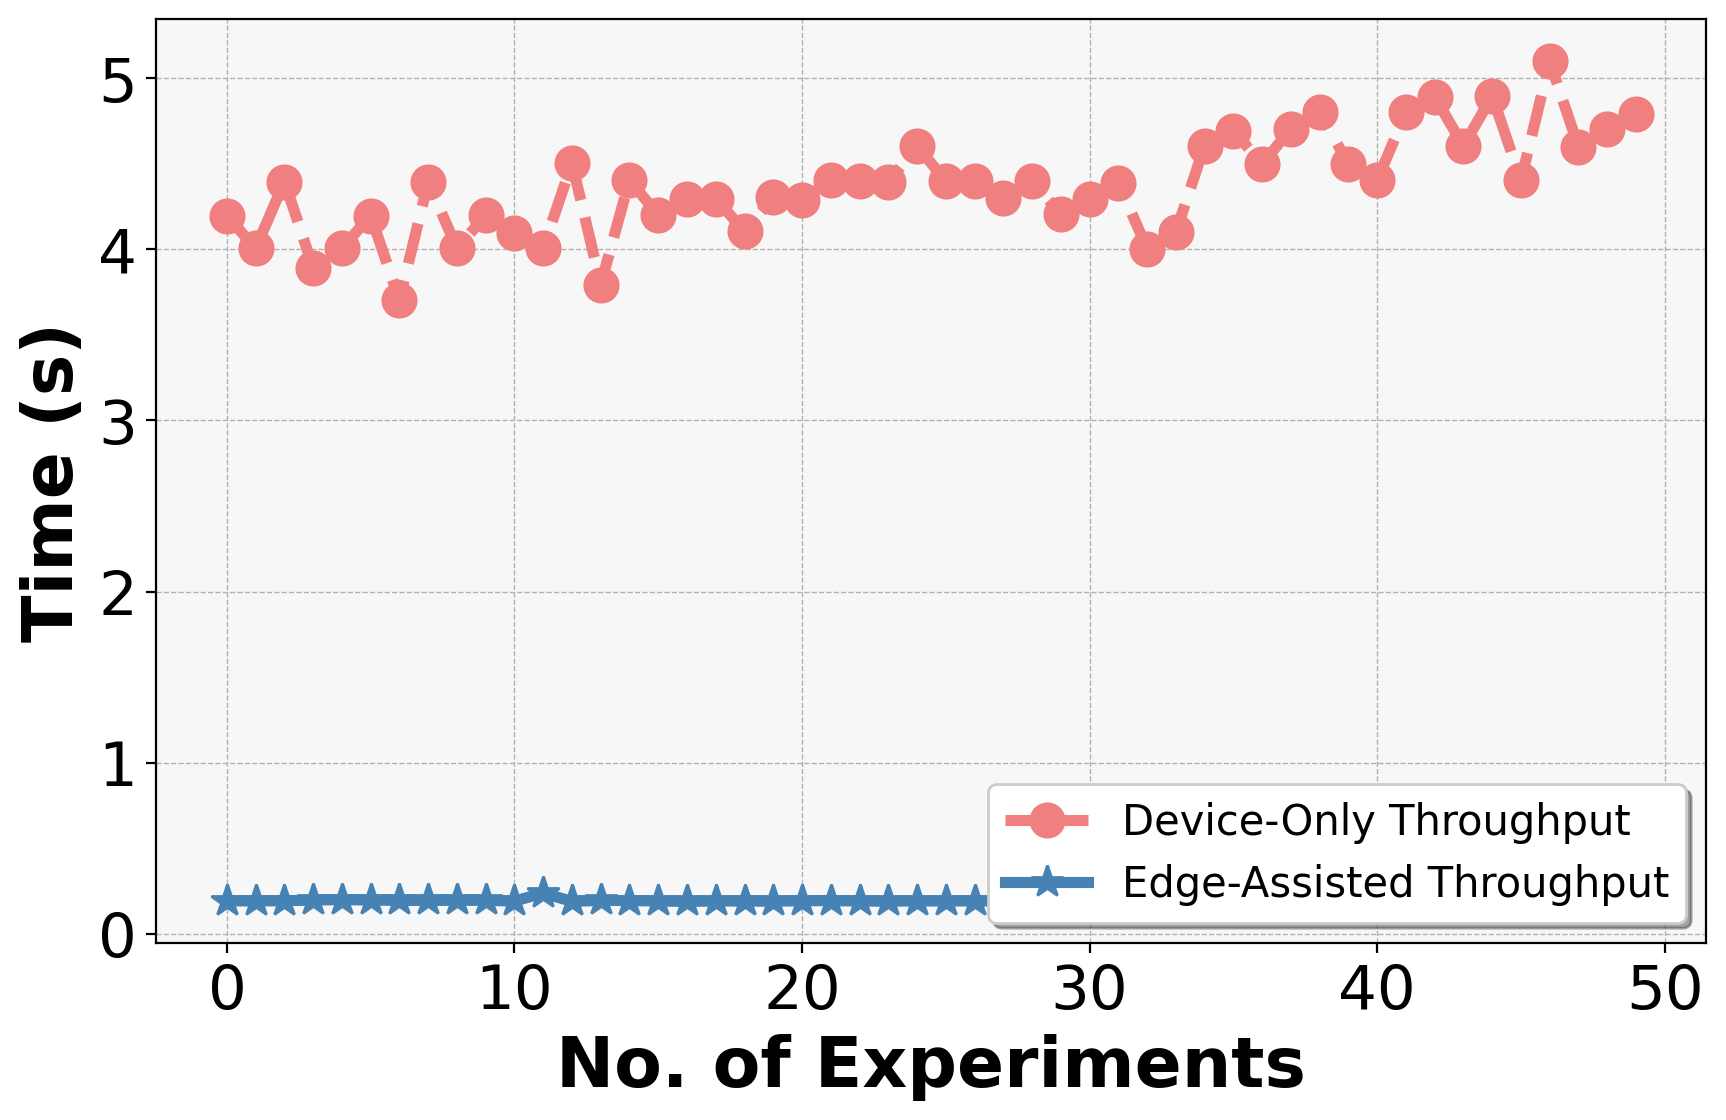

In [384]:
# Plot
plt.figure(figsize=(10, 6), dpi=200)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.plot(iot_times[50:], label='Device-Only Throughput', marker='o', markersize=12,
         linewidth=4, color='#f08080', linestyle='--')
plt.plot(edge_times[50:], label='Edge-Assisted Throughput', marker='*', markersize=12,
         linewidth=4, color='#4682b4', linestyle='-')

plt.xlabel('No. of Experiments', fontsize=25, fontweight='bold')
plt.ylabel('Time (s)', fontsize=25, fontweight='bold')


plt.legend(fontsize=15, loc='lower right', frameon=True, shadow=True, fancybox=True)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.show()


In [361]:
# Calculate throughput (certificates per second)
avg_device_throughput = 1 / np.mean(iot_times)
avg_edge_throughput = 1 / np.mean(edge_times)

# Improvement
improvement = ((avg_edge_throughput - avg_device_throughput) / avg_device_throughput) * 100

print(f"Device-only Throughput: {avg_device_throughput:.2f} certs/sec")
print(f"Edge-assisted Throughput: {avg_edge_throughput:.2f} certs/sec")
print(f"Percentage Improvement: {improvement:.2f}%")


Device-only Throughput: 0.24 certs/sec
Edge-assisted Throughput: 5.07 certs/sec
Percentage Improvement: 2033.13%
